# [Cleaned vs Dirty V2](https://www.kaggle.com/c/platesv2/overview)

[Решение, которым я вдохновлялась](https://www.kaggle.com/code/svyatoslavsokolov/cleaned-vs-dirty)

In [2]:
import copy
import cv2
import os
import shutil 
import time
import torch
import torchvision
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from torch import nn
from torch.nn import Module
from torch.utils.data import Dataset
from torchvision import transforms, models
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [3]:
class_names = ['cleaned', 'dirty']

In [4]:
data_folder = 'plates'
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

### Предобработка данных

In [5]:
class ImageHandler:
    
    def __init__(self, image_path):
        self.x00 = 0
        self.x00 = 0
        self.r00 = 0
        self.image_path = image_path
        img = cv2.imread(self.image_path)
        self.img = img
        self.mask = img       
            
    def find_circle(self):
        """Поиск окружности в пределах координат"""
        output = self.img.copy()    
        img = cv2.convertScaleAbs(self.img, alpha=1.2, beta=0.0)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 10,
                                   param1=10, param2=5, 
                                   minRadius=40, maxRadius=250)

        if circles is not None: 
            circles = np.round(circles[0, :]).astype("int")
                             
            for x, y, r in circles:
                if ((self.x00-15)<x<(self.x00+15)) and ((self.y00-15)<y<(self.y00+15)):
                    if r > self.r00: 
                        self.x00 = x
                        self.y00 = y
                        self.r00 = r

            if self.r00 == 0:
                ret, thresh = cv2.threshold(self.mask, 235, 255, 0)
                contours, hierarchy = cv2.findContours(thresh,
                                                       cv2.RETR_EXTERNAL, 
                                                       cv2.CHAIN_APPROX_TC89_KCOS)   
                c = max(contours, key=cv2.contourArea)
                (self.x00, self.y00), self.r00 = cv2.minEnclosingCircle(c)
            
    def find_сoordinates(self):
        """Нахождение координат центра фигуры"""
        ret,thresh = cv2.threshold(self.mask, 235, 255, 0)        
        M = cv2.moments(thresh)
        self.x00 = int(M["m10"] / M["m00"])
        self.y00 = int(M["m01"] / M["m00"])

    def remove_background(self):
        """Удаление фона"""
        mainRectSize = .08
        fgSize = .01
        img = self.img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_h, new_w = img.shape[:2]
        mask = np.zeros(img.shape[:2], np.uint8)
        bg_w = round(new_w * mainRectSize)
        bg_h = round(new_h * mainRectSize)
        bg_rect = (bg_w, bg_h, new_w - bg_w, new_h - bg_h)
        fg_w = round(new_w * (1 - fgSize) / 2)
        fg_h = round(new_h * (1 - fgSize) / 2)
        fg_rect = (fg_w, fg_h, new_w - fg_w, new_h - fg_h)
        cv2.rectangle(mask, fg_rect[:2], fg_rect[2:4], color=cv2.GC_FGD, thickness=-1)
        bgdModel1 = np.zeros((1, 65), np.float64)
        fgdModel1 = np.zeros((1, 65), np.float64)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 3, cv2.GC_INIT_WITH_RECT)
        cv2.rectangle(mask, bg_rect[:2], bg_rect[2:4], color=cv2.GC_PR_BGD, thickness=bg_w * 3)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 10, cv2.GC_INIT_WITH_MASK)   
        mask_result = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
        masked = cv2.bitwise_and(img, img, mask=mask_result)
        masked[mask_result < 2] = [255, 255, 255] 
        self.img = masked
        self.mask = mask_result

    def crop_and_save(self):
        """Обрезаем изображения для увеличения train датасета"""
        c_r_crop = (1.42*self.r00/2)
        self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),
                            int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        crop = self.img
        
        cv2.imwrite(self.image_path, crop)
        h, w = self.img.shape[:2] 
        c = min(h, w)

        for i in range (5, int(c/3), 5): 
            crop_img = self.img[i:h-i, i:w-i]    
            cv2.imwrite(f'{self.image_path[:-4]}_Crop_{str(i)}.jpg', crop_img)

        # Делим изображение на 4 части
        image1 = self.img[0:int(h//2), 0:int(w//2)]
        cv2.imwrite(self.image_path[:-4] +  'image1' + '.jpg', image1)
        image2 = self.img[int(h//2):h, int(w//2):w]
        cv2.imwrite(self.image_path[:-4] +  'image2' + '.jpg', image2)
        image3 = self.img[int(h//2):h, 0:int(w//2)]
        cv2.imwrite(self.image_path[:-4] +  'image3' + '.jpg', image3)
        image4 = self.img[0:int(h//2), int(w//2):w]
        cv2.imwrite(self.image_path[:-4] +  'image4' + '.jpg', image4)

    def crop_test_and_save(self):
        """
        Для test датасета оставляем изображение вырезанное по вписанному 
        (в найденный круг) квадрату
        """
        c_r_crop = (1.42 * self.r00 / 2)
        self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),
                            int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(self.image_path, self.img)

In [8]:
for image_class in class_names:
    images_folder = f'{data_folder}/{train_dir}/{image_class}'
    img_files = sorted([f for f in os.listdir(images_folder) if '.jpg' in f])

    for img_file in tqdm(img_files):
        image_path = f'{data_folder}/{train_dir}/{image_class}/{img_file}'
        out_img = ImageHandler(image_path)
        out_img.remove_background()
        out_img.find_сoordinates()
        out_img.find_circle()
        out_img.crop_and_save()

100%|██████████| 20/20 [00:56<00:00,  2.82s/it]


In [9]:
images_folder = f'{data_folder}/{test_dir}'
img_files = sorted([f for f in os.listdir(images_folder) if '.jpg' in f])

for img_file in tqdm(img_files):
    image_path = f'{data_folder}/{test_dir}/{img_file}'
    out_img = ImageHandler(image_path)
    out_img.remove_background()
    out_img.find_сoordinates()
    out_img.find_circle()
    out_img.crop_test_and_save()

100%|██████████| 744/744 [35:30<00:00,  2.86s/it]


### Создание валидационной выборки

Перенесем каждую 6-ую картинку в valid

In [18]:
for class_name in class_names:
    os.makedirs(f'{data_folder}/{valid_dir}/{class_name}', exist_ok=True)

In [12]:
images_folder = f'{data_folder}/{train_dir}/{image_class}'
img_files = sorted([f for f in os.listdir(images_folder) if '.jpg' in f])
len(img_files) * 2

548

In [19]:
for image_class in class_names:
    source_dir = f'{data_folder}/{train_dir}/{image_class}'
    for ind, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if ind % 6 == 0:
            os.replace(f'{data_folder}/{train_dir}/{image_class}/{file_name}',
                       f'{data_folder}/{valid_dir}/{image_class}/{file_name}')

100%|██████████| 275/275 [00:00<00:00, 277801.93it/s]


### Pytorch DataLoder (train, valid - директории с разметкой)

In [20]:
batch_size = 16
num_workers = 16

In [21]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

#### Предобработка 1

In [22]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [23]:
train_dataset = torchvision.datasets.ImageFolder(f'{data_folder}/{train_dir}', train_transforms)
valid_dataset = torchvision.datasets.ImageFolder(f'{data_folder}/{valid_dir}', test_transforms)

In [24]:
# Pytorch DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers)

valid_dataloader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=num_workers)

In [25]:
len(train_dataloader), len(train_dataset)

(29, 452)

In [26]:
def show_image_sample(n_images=10, columns=5):
    plt.figure(figsize=(20, 10))

    for i in range(n_images):
        X_batch, y_batch = next(iter(train_dataloader))
        plt.subplot(n_images / columns + 1, columns, i + 1)
        plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


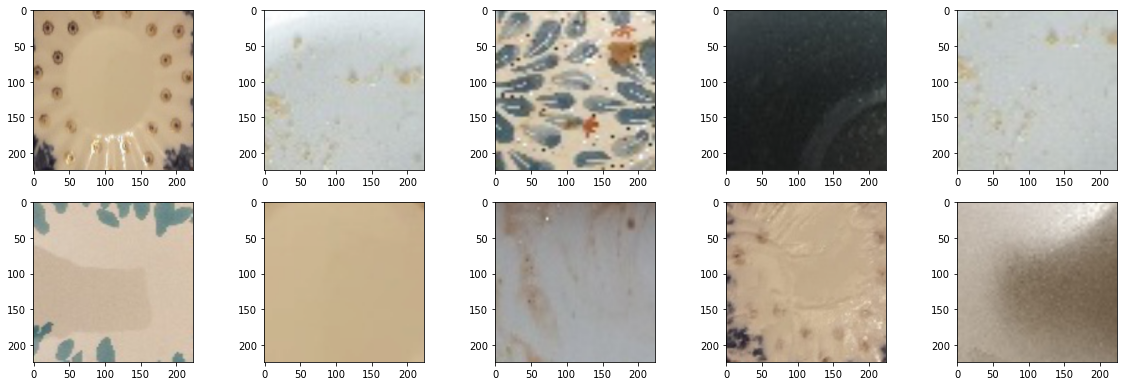

In [27]:
show_image_sample()

#### Предобработка 2

In [28]:
train_transforms = [
    transforms.Compose([
        transforms.CenterCrop(200),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
        
    transforms.Compose([
        transforms.CenterCrop(200),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
        
    transforms.Compose([
        transforms.RandomRotation(45),
        transforms.CenterCrop(200),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]), 
]

In [29]:
test_transforms = transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [30]:
train_dataset = torch.utils.data.ConcatDataset(
    [torchvision.datasets.ImageFolder(f'{data_folder}/{train_dir}', train_transform)
     for train_transform in train_transforms]
)

valid_dataset = torch.utils.data.ConcatDataset(
    [torchvision.datasets.ImageFolder(f'{data_folder}/{valid_dir}', train_transform)
     for train_transform in train_transforms]
)

In [31]:
# Pytorch DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers)

valid_dataloader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=num_workers)

In [32]:
len(train_dataloader), len(train_dataset)

(85, 1356)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

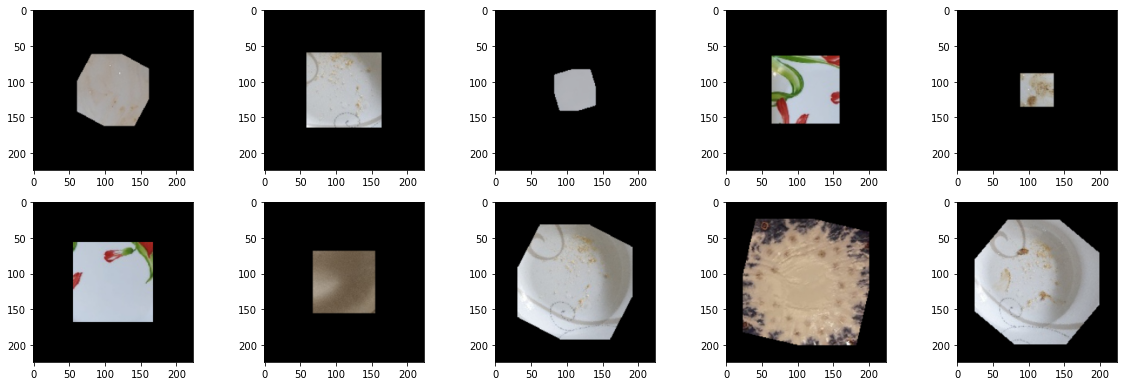

In [34]:
show_image_sample()

#### Предобработка 3

In [40]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255),
    transforms.Resize((224, 224)),    
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(),
    # Нормализация ResNet
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),     
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(),
    # Нормализация ResNet
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

In [41]:
dataset_transforms = dict()

dataset_transforms['orig'] = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

for crop in np.arange(70, 140, 5):
    dataset_transforms[str(crop)] = transforms.Compose([
        transforms.CenterCrop(crop),
        transforms.Resize((224, 224)),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [42]:
train_dataset = torchvision.datasets.ImageFolder(f'{data_folder}/{train_dir}', train_transforms)
val_dataset = torchvision.datasets.ImageFolder(f'{data_folder}/{valid_dir}', val_transforms)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=num_workers)

In [43]:
len(train_dataloader), len(train_dataset)

(29, 452)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


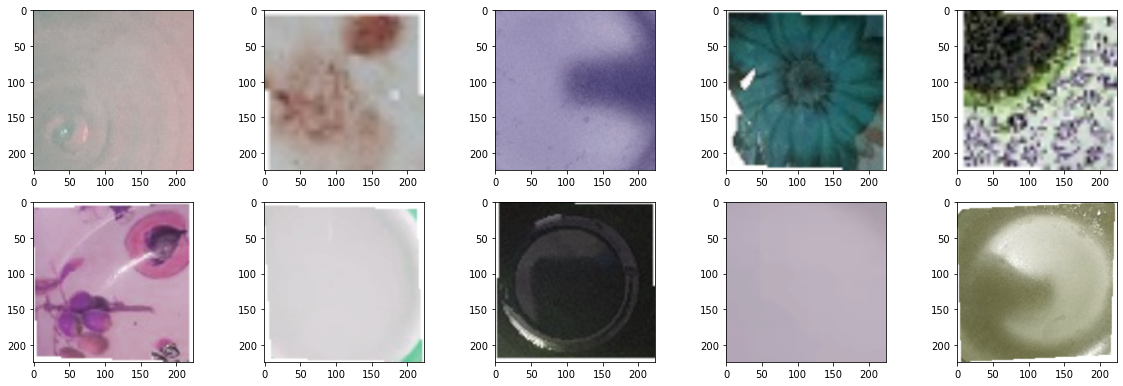

In [44]:
show_image_sample()

### Функция обучения модели

In [67]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    phases = ['train', 'valid']
    loss_hist = {phase: list() for phase in phases}
    acc_hist = {phase: list() for phase in phases}
 
    for epoch in range(num_epochs):
        for phase in phases:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else: 
                dataloader = val_dataloader
                model.eval()
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) 
                labels = labels.to(device) 
 
                # Обнуляем градиент,чтобы он не накапливался 
                optimizer.zero_grad()
 
                with torch.set_grad_enabled(phase == 'train'):
                    # Считаем предикты
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    # Получаем класс
                    preds_class = preds.argmax(dim=1)
                
                    if phase == 'train':
                        # Считаем градиент 
                        loss_value.backward()
                        # Считаем шаг градиентного спуска
                        optimizer.step()
 
                # Статистики
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()
 
            epoch_loss = round(running_loss / len(dataloader), 3)
            loss_hist[phase].append(epoch_loss)

            epoch_acc = round(running_acc / len(dataloader), 3)
            acc_hist[phase].append(epoch_acc)

        # Monitoring
        progress = f'{epoch+1}/{NUM_EPOCH}'
        loss_info = f"train loss: {loss_hist['train'][-1]}, valid loss: {loss_hist['valid'][-1]}"
        acc_info = f"train acc: {acc_hist['train'][-1]}, valid acc: {acc_hist['valid'][-1]}"
        print(f'Epoch [{progress}], {loss_info}, {acc_info}')

    return model, loss_hist, acc_hist

## AlexNet from scratch

In [68]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6400, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [69]:
LEARNING_RATE = 0.01
NUM_EPOCH = 10

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [71]:
model = AlexNet(num_classes=2)
model = model.to(device)

In [72]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [73]:
model, loss_hist, acc_hist = train_model(model=model,
                                         loss=torch.nn.CrossEntropyLoss(),
                                         optimizer=optimizer,
                                         scheduler=scheduler,
                                         num_epochs=NUM_EPOCH)

100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


Epoch [1/10], train loss: 0.857, valid loss: 0.7, train acc: 0.476, valid acc: 0.557


100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


Epoch [2/10], train loss: 0.718, valid loss: 0.809, train acc: 0.569, valid acc: 0.526


100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


Epoch [3/10], train loss: 0.684, valid loss: 0.731, train acc: 0.629, valid acc: 0.554


100%|██████████| 6/6 [00:03<00:00,  1.50it/s]


Epoch [4/10], train loss: 0.643, valid loss: 0.955, train acc: 0.675, valid acc: 0.562


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


Epoch [5/10], train loss: 0.614, valid loss: 0.644, train acc: 0.69, valid acc: 0.629


100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


Epoch [6/10], train loss: 0.624, valid loss: 0.714, train acc: 0.659, valid acc: 0.583


100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


Epoch [7/10], train loss: 0.58, valid loss: 0.622, train acc: 0.718, valid acc: 0.626


100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


Epoch [8/10], train loss: 0.558, valid loss: 0.63, train acc: 0.72, valid acc: 0.616


100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


Epoch [9/10], train loss: 0.522, valid loss: 0.599, train acc: 0.763, valid acc: 0.673


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]

Epoch [10/10], train loss: 0.51, valid loss: 0.576, train acc: 0.793, valid acc: 0.699


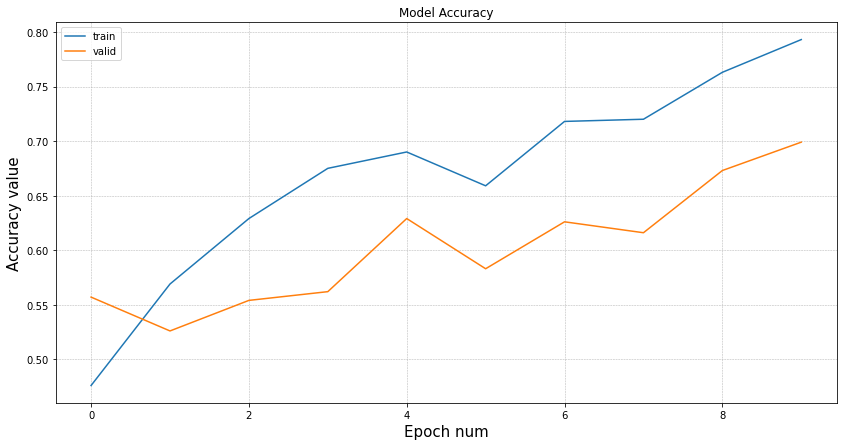

In [75]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

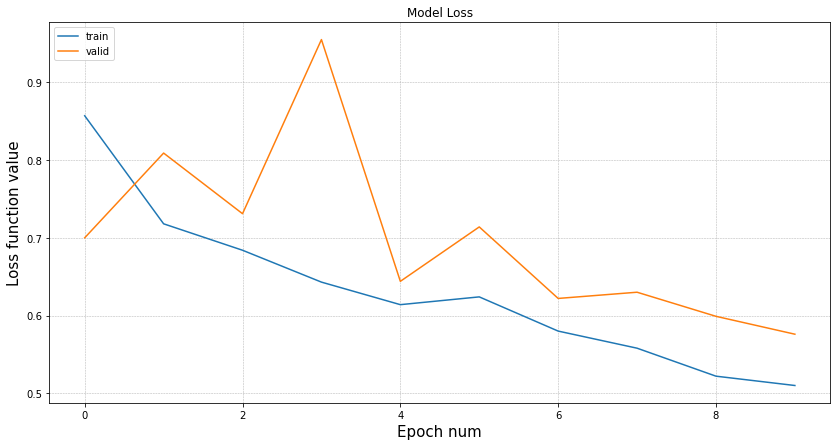

In [76]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

## Pretrained ResNet18

In [77]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

In [78]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [79]:
LEARNING_RATE = 0.001
NUM_EPOCH = 30

In [80]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [81]:
model, loss_hist, acc_hist = train_model(model=model,
                                         loss=loss,
                                         optimizer=optimizer,
                                         scheduler=scheduler,
                                         num_epochs=NUM_EPOCH)

100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


Epoch [1/30], train loss: 0.663, valid loss: 0.572, train acc: 0.623, valid acc: 0.722


100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


Epoch [2/30], train loss: 0.534, valid loss: 0.602, train acc: 0.748, valid acc: 0.636


100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


Epoch [3/30], train loss: 0.467, valid loss: 0.501, train acc: 0.774, valid acc: 0.781


100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Epoch [4/30], train loss: 0.484, valid loss: 0.461, train acc: 0.767, valid acc: 0.774


100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch [5/30], train loss: 0.386, valid loss: 0.427, train acc: 0.86, valid acc: 0.852


100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Epoch [6/30], train loss: 0.333, valid loss: 0.38, train acc: 0.869, valid acc: 0.849


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Epoch [7/30], train loss: 0.334, valid loss: 0.372, train acc: 0.869, valid acc: 0.839


100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


Epoch [8/30], train loss: 0.283, valid loss: 0.391, train acc: 0.907, valid acc: 0.857


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Epoch [9/30], train loss: 0.322, valid loss: 0.419, train acc: 0.89, valid acc: 0.808


100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Epoch [10/30], train loss: 0.31, valid loss: 0.364, train acc: 0.894, valid acc: 0.818


100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Epoch [11/30], train loss: 0.334, valid loss: 0.416, train acc: 0.884, valid acc: 0.795


100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Epoch [12/30], train loss: 0.333, valid loss: 0.437, train acc: 0.864, valid acc: 0.808


100%|██████████| 6/6 [00:04<00:00,  1.24it/s]


Epoch [13/30], train loss: 0.317, valid loss: 0.389, train acc: 0.856, valid acc: 0.805


100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


Epoch [14/30], train loss: 0.329, valid loss: 0.379, train acc: 0.881, valid acc: 0.812


100%|██████████| 6/6 [00:04<00:00,  1.22it/s]


Epoch [15/30], train loss: 0.334, valid loss: 0.378, train acc: 0.864, valid acc: 0.808


100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Epoch [16/30], train loss: 0.334, valid loss: 0.38, train acc: 0.864, valid acc: 0.837


100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


Epoch [17/30], train loss: 0.295, valid loss: 0.353, train acc: 0.912, valid acc: 0.839


100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Epoch [18/30], train loss: 0.308, valid loss: 0.402, train acc: 0.897, valid acc: 0.808


100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Epoch [19/30], train loss: 0.315, valid loss: 0.446, train acc: 0.879, valid acc: 0.748


100%|██████████| 6/6 [00:04<00:00,  1.24it/s]


Epoch [20/30], train loss: 0.356, valid loss: 0.338, train acc: 0.849, valid acc: 0.839


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Epoch [21/30], train loss: 0.309, valid loss: 0.394, train acc: 0.875, valid acc: 0.772


100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


Epoch [22/30], train loss: 0.32, valid loss: 0.376, train acc: 0.875, valid acc: 0.849


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Epoch [23/30], train loss: 0.334, valid loss: 0.338, train acc: 0.869, valid acc: 0.873


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Epoch [24/30], train loss: 0.342, valid loss: 0.396, train acc: 0.86, valid acc: 0.818


100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Epoch [25/30], train loss: 0.321, valid loss: 0.413, train acc: 0.884, valid acc: 0.776


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


Epoch [26/30], train loss: 0.31, valid loss: 0.376, train acc: 0.881, valid acc: 0.797


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Epoch [27/30], train loss: 0.355, valid loss: 0.348, train acc: 0.856, valid acc: 0.881


100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


Epoch [28/30], train loss: 0.319, valid loss: 0.364, train acc: 0.89, valid acc: 0.862


100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


Epoch [29/30], train loss: 0.32, valid loss: 0.373, train acc: 0.886, valid acc: 0.833


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

Epoch [30/30], train loss: 0.314, valid loss: 0.367, train acc: 0.881, valid acc: 0.834


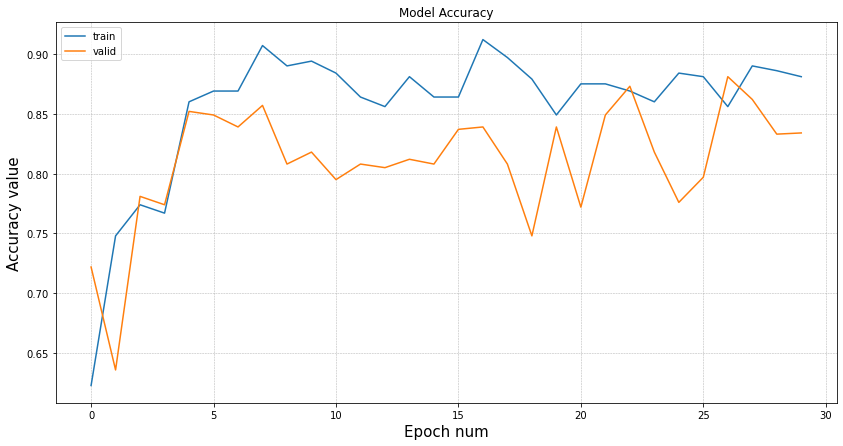

In [86]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

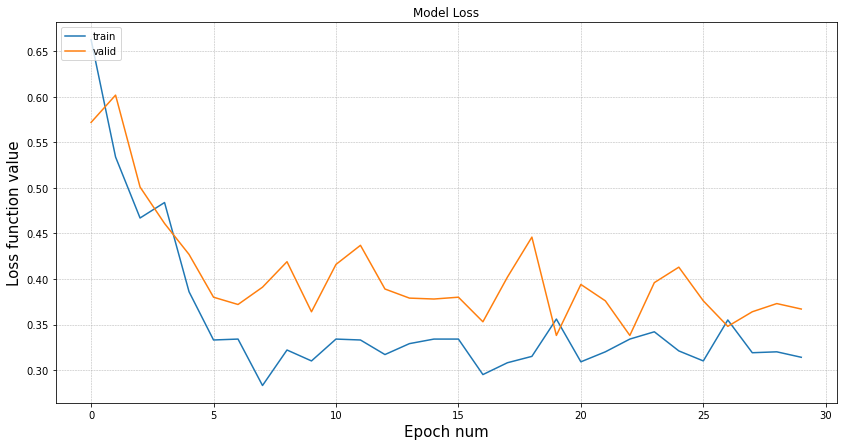

In [87]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

## Pretrained ResNet152

In [88]:
model = models.resnet152(pretrained=True) 
          
for param in model.parameters():
    param.requires_grad = False 
    
model.fc = torch.nn.Linear(model.fc.in_features, 2)

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [90]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [91]:
model, loss, acc = train_model(model, loss, optimizer, scheduler, num_epochs=40)

100%|██████████| 6/6 [00:31<00:00,  5.25s/it]


Epoch [1/30], train loss: 0.559, valid loss: 0.531, train acc: 0.705, valid acc: 0.74


100%|██████████| 6/6 [00:24<00:00,  4.15s/it]


Epoch [2/30], train loss: 0.507, valid loss: 0.402, train acc: 0.735, valid acc: 0.844


100%|██████████| 6/6 [00:30<00:00,  5.09s/it]


Epoch [3/30], train loss: 0.333, valid loss: 0.609, train acc: 0.871, valid acc: 0.667


100%|██████████| 6/6 [00:29<00:00,  4.84s/it]


Epoch [4/30], train loss: 0.372, valid loss: 0.284, train acc: 0.828, valid acc: 0.904


100%|██████████| 6/6 [00:33<00:00,  5.62s/it]


Epoch [5/30], train loss: 0.334, valid loss: 0.468, train acc: 0.853, valid acc: 0.764


100%|██████████| 6/6 [00:28<00:00,  4.83s/it]


Epoch [6/30], train loss: 0.343, valid loss: 0.242, train acc: 0.825, valid acc: 0.927


100%|██████████| 6/6 [00:31<00:00,  5.21s/it]


Epoch [7/30], train loss: 0.26, valid loss: 0.271, train acc: 0.922, valid acc: 0.904


100%|██████████| 6/6 [00:26<00:00,  4.45s/it]


Epoch [8/30], train loss: 0.29, valid loss: 0.269, train acc: 0.884, valid acc: 0.873


100%|██████████| 6/6 [00:21<00:00,  3.64s/it]


Epoch [9/30], train loss: 0.295, valid loss: 0.24, train acc: 0.886, valid acc: 0.938


100%|██████████| 6/6 [00:20<00:00,  3.34s/it]


Epoch [10/30], train loss: 0.277, valid loss: 0.321, train acc: 0.884, valid acc: 0.837


100%|██████████| 6/6 [00:22<00:00,  3.83s/it]


Epoch [11/30], train loss: 0.274, valid loss: 0.258, train acc: 0.897, valid acc: 0.881


100%|██████████| 6/6 [00:31<00:00,  5.24s/it]


Epoch [12/30], train loss: 0.268, valid loss: 0.259, train acc: 0.901, valid acc: 0.912


100%|██████████| 6/6 [00:23<00:00,  3.98s/it]


Epoch [13/30], train loss: 0.277, valid loss: 0.304, train acc: 0.879, valid acc: 0.87


100%|██████████| 6/6 [00:24<00:00,  4.16s/it]


Epoch [14/30], train loss: 0.244, valid loss: 0.286, train acc: 0.907, valid acc: 0.901


100%|██████████| 6/6 [00:22<00:00,  3.81s/it]


Epoch [15/30], train loss: 0.266, valid loss: 0.268, train acc: 0.897, valid acc: 0.914


100%|██████████| 6/6 [00:23<00:00,  3.90s/it]


Epoch [16/30], train loss: 0.25, valid loss: 0.292, train acc: 0.903, valid acc: 0.87


100%|██████████| 6/6 [00:22<00:00,  3.82s/it]


Epoch [17/30], train loss: 0.258, valid loss: 0.265, train acc: 0.907, valid acc: 0.891


100%|██████████| 6/6 [00:22<00:00,  3.76s/it]


Epoch [18/30], train loss: 0.271, valid loss: 0.305, train acc: 0.897, valid acc: 0.862


100%|██████████| 6/6 [00:24<00:00,  4.01s/it]


Epoch [19/30], train loss: 0.276, valid loss: 0.269, train acc: 0.903, valid acc: 0.881


100%|██████████| 6/6 [00:22<00:00,  3.73s/it]


Epoch [20/30], train loss: 0.266, valid loss: 0.249, train acc: 0.897, valid acc: 0.914


100%|██████████| 6/6 [00:21<00:00,  3.65s/it]


Epoch [21/30], train loss: 0.263, valid loss: 0.268, train acc: 0.907, valid acc: 0.881


100%|██████████| 6/6 [00:21<00:00,  3.64s/it]


Epoch [22/30], train loss: 0.31, valid loss: 0.257, train acc: 0.873, valid acc: 0.948


100%|██████████| 6/6 [00:21<00:00,  3.60s/it]


Epoch [23/30], train loss: 0.285, valid loss: 0.296, train acc: 0.892, valid acc: 0.878


100%|██████████| 6/6 [00:21<00:00,  3.62s/it]


Epoch [24/30], train loss: 0.297, valid loss: 0.264, train acc: 0.873, valid acc: 0.904


100%|██████████| 6/6 [00:21<00:00,  3.55s/it]


Epoch [25/30], train loss: 0.252, valid loss: 0.213, train acc: 0.903, valid acc: 0.904


100%|██████████| 6/6 [00:22<00:00,  3.76s/it]


Epoch [26/30], train loss: 0.265, valid loss: 0.295, train acc: 0.892, valid acc: 0.855


100%|██████████| 6/6 [00:21<00:00,  3.55s/it]


Epoch [27/30], train loss: 0.248, valid loss: 0.279, train acc: 0.907, valid acc: 0.87


100%|██████████| 6/6 [00:17<00:00,  2.84s/it]


Epoch [28/30], train loss: 0.273, valid loss: 0.271, train acc: 0.897, valid acc: 0.896


100%|██████████| 6/6 [00:16<00:00,  2.72s/it]


Epoch [29/30], train loss: 0.236, valid loss: 0.221, train acc: 0.916, valid acc: 0.938


100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


Epoch [30/30], train loss: 0.247, valid loss: 0.234, train acc: 0.907, valid acc: 0.927


100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


Epoch [31/30], train loss: 0.261, valid loss: 0.264, train acc: 0.899, valid acc: 0.922


100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


Epoch [32/30], train loss: 0.254, valid loss: 0.313, train acc: 0.907, valid acc: 0.896


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Epoch [33/30], train loss: 0.257, valid loss: 0.233, train acc: 0.897, valid acc: 0.914


100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


Epoch [34/30], train loss: 0.269, valid loss: 0.264, train acc: 0.892, valid acc: 0.927


100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


Epoch [35/30], train loss: 0.249, valid loss: 0.314, train acc: 0.909, valid acc: 0.896


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


Epoch [36/30], train loss: 0.259, valid loss: 0.255, train acc: 0.897, valid acc: 0.946


100%|██████████| 6/6 [00:15<00:00,  2.67s/it]


Epoch [37/30], train loss: 0.269, valid loss: 0.291, train acc: 0.894, valid acc: 0.868


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


Epoch [38/30], train loss: 0.242, valid loss: 0.305, train acc: 0.905, valid acc: 0.849


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


Epoch [39/30], train loss: 0.239, valid loss: 0.259, train acc: 0.92, valid acc: 0.925


100%|██████████| 6/6 [00:15<00:00,  2.63s/it]

Epoch [40/30], train loss: 0.263, valid loss: 0.254, train acc: 0.899, valid acc: 0.938


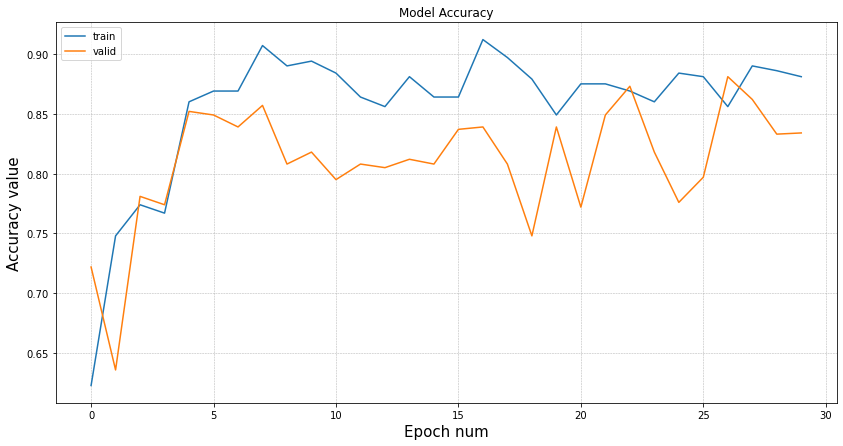

In [92]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

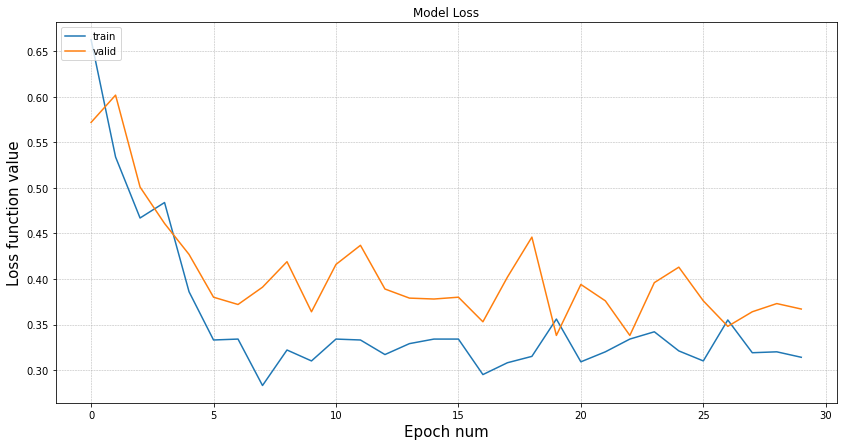

In [93]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

## Запишем предсказания для тестовой выборки

In [116]:
shutil.copytree(f'{data_folder}/{test_dir}', f'{data_folder}/{test_dir}/unknown')

'plates/test/unknown'

In [117]:
class_folder = f'{data_folder}/{test_dir}/unknown'
test_image_pathes = []

for file in sorted(os.listdir(class_folder)):
    if '.jpg' in file:
        test_image_pathes.append(f'{class_folder}/{file}')

print(f'Test: {len(test_image_pathes)}')

Test: 744


In [129]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder): 
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [130]:
df = pd.DataFrame

for (i,tranforms) in dataset_transforms.items():
    test_dataset = ImageFolderWithPaths(f'{data_folder}/{test_dir}', tranforms) 

    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=0)
    model.eval()

    test_predictions = []
    test_img_paths = []

    for inputs, labels, paths in tqdm(test_dataloader):  
        inputs = inputs.to(device) 
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            preds = model(inputs)

        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()
        ) 

        test_img_paths.extend(paths)
    test_predictions = np.concatenate(test_predictions)

    submission_dict = {'id': test_img_paths, 'label': test_predictions}
    submission_df = pd.DataFrame.from_dict(submission_dict)
    submission_df['id'] = submission_df['id'].str.replace(
        f'{data_folder}/{test_dir}/unknown/', '')
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)
    
    try:
        df = df.merge(submission_df, how='inner', on='id')
    except BaseException:
        df = submission_df

100%|██████████| 47/47 [02:41<00:00,  3.44s/it]


In [131]:
df.head()

,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label
id,,,,,,,,,,,,,,,
0000,0.995189,0.996825,0.998103,0.997257,0.996872,0.996077,0.997409,0.996901,0.994547,0.995906,0.996818,0.997894,0.998248,0.998636,0.998814
0001,0.899605,0.942359,0.933363,0.929508,0.972856,0.974348,0.980251,0.899329,0.963298,0.984064,0.970769,0.962042,0.966558,0.949682,0.791247
0002,0.459118,0.922112,0.901846,0.950761,0.891888,0.895902,0.768902,0.882664,0.758285,0.827381,0.654544,0.628511,0.664024,0.564122,0.507957
0003,0.981176,0.991405,0.987325,0.991690,0.983391,0.995263,0.975499,0.969889,0.975262,0.964597,0.959923,0.965372,0.973343,0.981176,0.805310
0004,0.558769,0.976773,0.977559,0.944750,0.913730,0.894360,0.887488,0.882661,0.810208,0.814308,0.756917,0.730591,0.756250,0.823856,0.686448


In [132]:
df['mean'] = df.mean(axis=1)
df.drop(df.columns[:-1], axis='columns', inplace=True)
df['label'] = df['mean'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
df.drop(df.columns[:-1], axis='columns', inplace=True)
df.head()

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty


In [133]:
df.to_csv('submission.csv')